## ILC Method

***

### Authors:

   * Andrés Felipe Duque Bran

   * Melih Aktas

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
# Frequencies of Planck
HF = [100, 143, 217, 353, 545, 857] # [GHz]

In [3]:
# Get smooth values from PSF
R = fits.getdata("../data/initial/HFI_RIMO_R2.00.fits", 2)
FWHM = R[:]["FWHM"]

In [4]:
# Create DataFrame with frequencies and FWHM
data = pd.DataFrame(data=[HF,FWHM]).T
data.columns = ["Frequency", "FWHM"]

In [5]:
# Getting the PSF map for each frequency
data["PSF Map"] = data["Frequency"].map(
    lambda x: hp.read_map(f"../data/generated/HFI_{int(x)}.fits")
)

In [6]:
# Get the covariance matrix for all maps
T = np.array(data["PSF Map"].to_list())
V = np.cov(T)

In [7]:
# Determine the CMB
S = np.divide(
        np.matmul(
            np.matmul(
                np.ones(V.shape[0]),
                np.linalg.inv(V)
            ),
            T
        ),
        np.matmul(
            np.matmul( np.ones(V.shape[0]), np.linalg.inv(V)),
            np.ones(V.shape[0])
        )
)

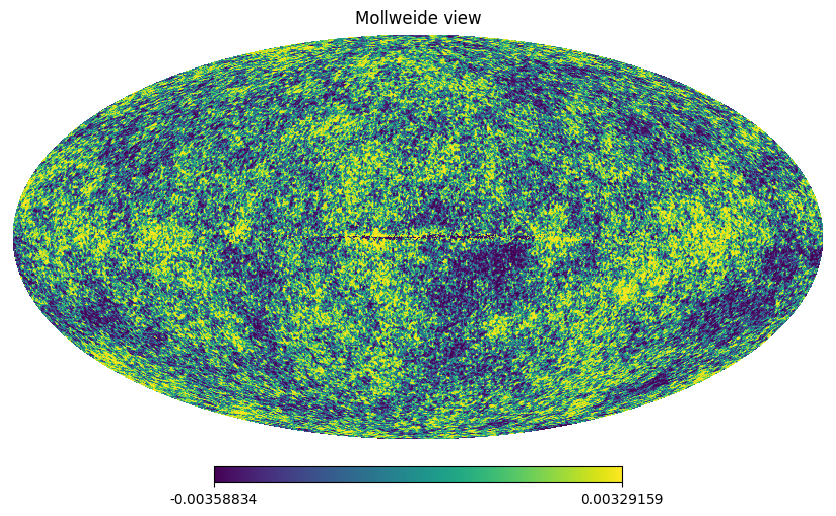

In [8]:
# Display view of the CMB
hp.mollview(S, norm = "hist")

In [9]:
# Write map of CMB into a healpix FITS file.
hp.write_map(
        "../data/generated/CMB.fits",
        S,
        overwrite=True
    )

setting the output map dtype to [dtype('float64')]


In [10]:
# Read Frequency Map at 857 GHz 
HFI_857 = hp.read_map(f"../data/generated/HFI_857.fits")

In [12]:
# Mask functions
maskHFI_857s = np.where(HFI_857>2.1*np.average(HFI_857),0,1)
maskHFI_857m = np.where(HFI_857>1*np.average(HFI_857),0,1)
maskHFI_857b = np.where(HFI_857>0.4*np.average(HFI_857),0,1)

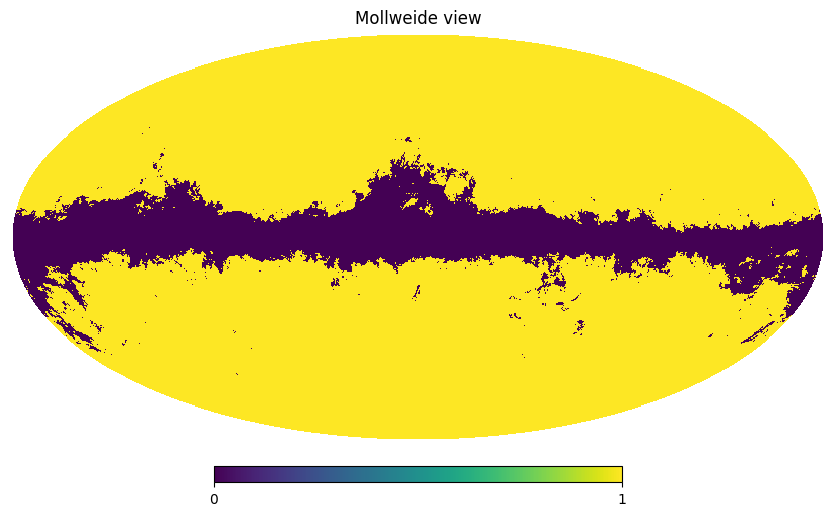

In [19]:
# View the mask
hp.mollview(maskHFI_857m, norm = "hist")

In [13]:
# Masked maps, increased to 2048 nside
MapS = hp.ud_grade(S, 2048)
MapSs = hp.ud_grade(S*maskHFI_857s, 2048)
MapSm = hp.ud_grade(S*maskHFI_857m, 2048)
MapSb = hp.ud_grade(S*maskHFI_857b, 2048)

In [16]:
# Power spectrum 
Y = hp.sphtfunc.anafast(MapS)
Ys = hp.sphtfunc.anafast(MapSs)
Ym = hp.sphtfunc.anafast(MapSm)
Yb = hp.sphtfunc.anafast(MapSb)

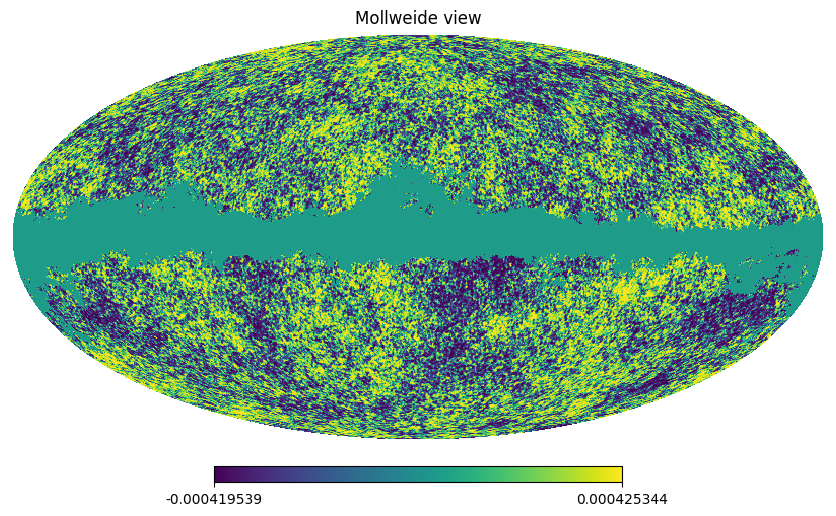

In [20]:
# View the Map after applying the mask
hp.mollview(MapSm, norm = "hist")

In [17]:
# reverting functions we need
revertpix = hp.sphtfunc.pixwin(2048) # this has size 3 times nside minus 1
revertgaus = hp.sphtfunc.gauss_beam((10*np.pi/(60*180)), 3*2048 -1) 

In [18]:
# Gauss one is explained in the document. 
# The pixel one should divide the function to revert the effect
PY = revertgaus**(-2) * Y / revertpix
PYs = revertgaus**(-2) * Ys / revertpix
PYm = revertgaus**(-2) * Ym / revertpix
PYb = revertgaus**(-2) * Yb / revertpix

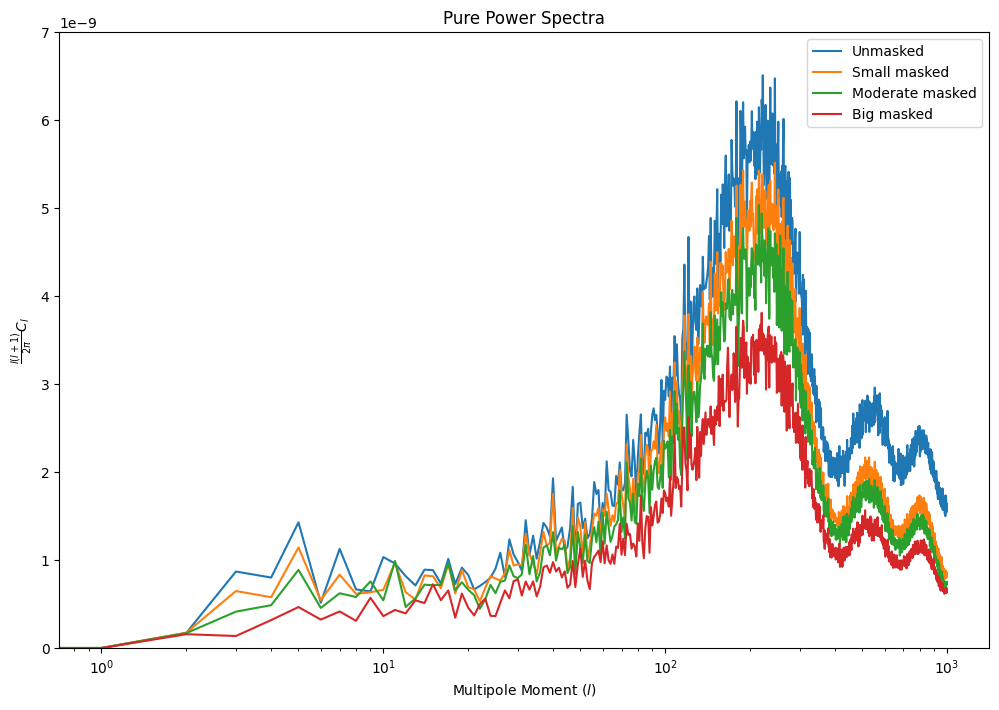

In [21]:
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(12, 8, forward=True)

x = np.arange(1000)
axis.set_xscale("log")
axis.set_title("Pure Power Spectra")
axis.plot(x, (x*(x+1))/(2*np.pi)*PY[0:1000], label = "Unmasked")
axis.plot(x, (x*(x+1))/(2*np.pi)*PYs[0:1000], label = "Small masked")
axis.plot(x, (x*(x+1))/(2*np.pi)*PYm[0:1000], label = "Moderate masked")
axis.plot(x, (x*(x+1))/(2*np.pi)*PYb[0:1000], label = "Big masked")
axis.set_xlabel(r"Multipole Moment ($l$)")
axis.set_ylabel(r"$\frac{l(l+1)}{2 \pi } C_{l} $")
axis.set_ylim([0, 7 * 1e-9])
axis.legend()
plt.show()

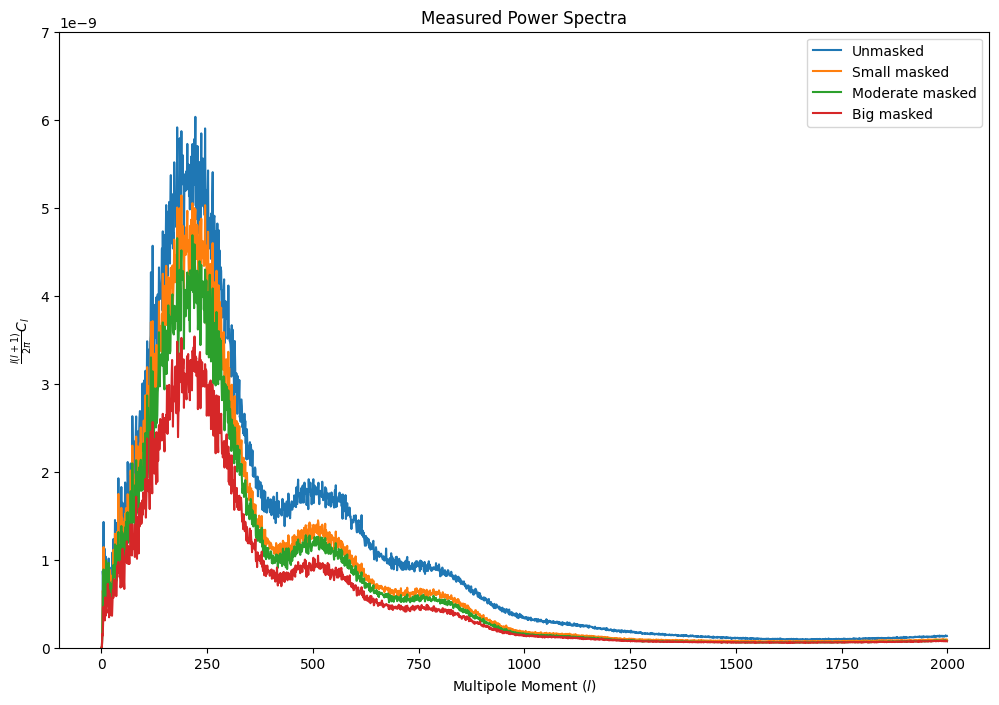

In [22]:
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(12, 8, forward=True)

x = np.arange(2000)
axis.set_title("Measured Power Spectra")
axis.plot(x, (x*(x+1))/(2*np.pi)*Y[0:2000], label = "Unmasked")
axis.plot(x, (x*(x+1))/(2*np.pi)*Ys[0:2000], label = "Small masked")
axis.plot(x, (x*(x+1))/(2*np.pi)*Ym[0:2000], label = "Moderate masked")
axis.plot(x, (x*(x+1))/(2*np.pi)*Yb[0:2000], label = "Big masked")
axis.set_xlabel(r"Multipole Moment ($l$)")
axis.set_ylabel(r"$\frac{l(l+1)}{2 \pi } C_{l} $")
axis.set_ylim([0, 0.7 * 1e-8])
axis.legend()
plt.show()